In [4]:
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from IPython import display

from scipy.spatial.transform import Rotation as R

import math
from copy import copy
import glob

In [5]:
centre_list = []
for f in glob.glob('./results/order*'):
    obj_ids = np.load(f)
    if obj_ids[0]==0:
        centre_list.append(f)

In [6]:
f = np.random.choice(centre_list)
run = int(f.split('_')[1][:-4])

ims = np.load('./results/ims_%d.npy'%run)
states = np.load('./results/states_%d.npy'%run)
obj_ids = np.load('./results/order_%d.npy'%run)

for i, im in enumerate(ims):
    if i %10 == 0:
        plt.cla()
        plt.clf()
        plt.subplot(2,2,1)
        plt.imshow(im[0])
        plt.subplot(2,2,2)
        plt.imshow(im[1])
        plt.subplot(2,1,2)
        plt.plot(np.vstack(states)[0:i,:])
        display.clear_output(wait=True)
        display.display(plt.gcf())

ValueError: 'a' cannot be empty unless no samples are taken

In [4]:
obj_list = []
im_list = []
for f in centre_list:
    run = int(f.split('_')[1][:-4])

    ims = np.load('./results/ims_%d.npy'%run)
    obj_ids = np.load('./results/order_%d.npy'%run)
    
    obj_list.append(obj_ids)
    im_list.append(ims[-1][0])

In [5]:
# Action sequencing using visual permutations 
# ordered = P(im) disordered

# pick and place, save location of pick/place
# P*seq of moves = 

# Train, arbitrary, a_im -> ordered 

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [7]:
# Set up pytorch dataloader
class Sampler(Dataset):
    
    def __init__(self, ims, actions):
        
        self.ims = torch.FloatTensor(ims.astype('float'))
        self.actions = torch.LongTensor(actions.astype('int'))
        
        
    def __len__(self):
        
        return self.ims.shape[0]
    
    def __getitem__(self, index):
        
        im = self.ims[index,:,:,:]
        actions = self.actions[index,:]
        return im, actions


In [8]:
dataset = Sampler(np.swapaxes(np.stack(im_list),1,3),np.stack(obj_list))

train_dataset,test_dataset = torch.utils.data.random_split(dataset, [100,len(im_list)-100])

In [9]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class BCNet(nn.Module):

    def __init__(self, latent_dim=16, image_channels=3, K=6):
        super(BCNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, latent_dim),
        )
        
        # Sinkhorn params
        self.latent_dim = latent_dim
        self.K = K
        
        self.criterion = nn.CrossEntropyLoss()

        self.fc = nn.Sequential(
                        nn.Linear(self.latent_dim, K*K))
    
    def forward(self, im):
        
        latent = self.encoder(im)
        y = self.fc(latent)
        logits = torch.nn.functional.softmax(y.reshape(-1,self.K,self.K),dim=-1)
        
        return logits
    
    def loss(self, seq, im):
        
        seq_logits = self.forward(im)
        
        return self.criterion(seq_logits,seq), seq_logits

In [11]:
bc = BCNet(latent_dim=16, image_channels=3, K=6)
optimizer = torch.optim.Adam(bc.parameters(), lr=3e-4)

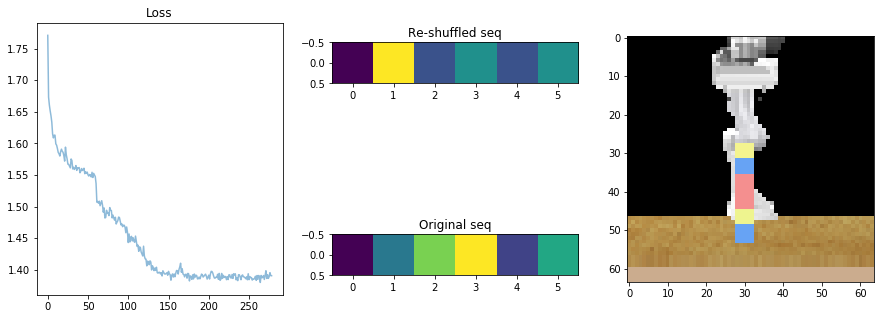

In [ ]:
plt.figure(figsize=(15,5))

n_epochs = 500
losses = []

for j in range(n_epochs):
    
    batch_losses = []
    for im, seq in train_loader:
    
        loss, seq_pred = bc.loss(seq, im)
        
        batch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    losses.append(np.mean(batch_losses))
    
    plt.clf()
    plt.cla()
    plt.subplot(1,3,1)
    plt.plot(losses,alpha=0.5)
    plt.title('Loss')

    
    plt.subplot(3,3,2)
    seq_p = np.argmax(seq_pred[0,:,:].detach().numpy(),-1)
    plt.imshow(seq_p.reshape(1,-1))
    plt.title('Re-shuffled seq')
    
    plt.subplot(3,3,8)
    plt.imshow(seq[0,:].detach().numpy().reshape(1,-1))
    plt.title('Original seq')
    
    plt.subplot(1,3,3)
    plt.imshow(np.swapaxes(im[0,:,:,:].detach().numpy(),0,2))
    
        
    display.clear_output(wait=True)
    display.display(plt.gcf())
    

In [ ]:
# Action sequencing using classification

# Exps -> compare to classification baseline
# Exps -> generalisation with respect to unseen configs?
# Exps -> 

In [ ]:
from pyrep import PyRep
from pyrep.robots.arms.panda import Panda
from pyrep.robots.end_effectors.panda_gripper import PandaGripper
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from IPython import display

from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape

from scipy.spatial.transform import Rotation as R

import math
from copy import copy

In [ ]:
pr = PyRep()
pr.launch('./assets/scene_panda.ttt', headless=False)

In [ ]:
agent = Panda()
gripper = PandaGripper()

In [ ]:
home_pos = agent.get_tip().get_position()
home_orient = agent.get_tip().get_orientation()

In [ ]:
def grasp(grip=False):
    if grip:
        pos = 0.1
    else:
        pos = 0.9
    actuated = False
    ims = []
    states = []
    while not actuated:
        actuated = gripper.actuate(pos,0.1)
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [ ]:
def move_above_object(object_name='',offset=0.05):
    pos = agent.get_object(object_name).get_position()
    pos[2] = pos[2] + offset
    orient = [-np.pi,0,np.pi/2]

    path = agent.get_path(position=pos,euler=orient)

    done = False
    ims = []
    states = []
    while not done:
        done = path.step()
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [ ]:
def get_image():
    cam = agent.get_object('Vision_sensor_front')
    im0 = cam.capture_rgb()
    cam1 = agent.get_object('Vision_sensor')
    im1 = cam1.capture_rgb()
    pr.step()
    return im0, im1

In [ ]:
bc.eval()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
from scipy.stats import kendalltau

In [ ]:
tau_list = []
for im,seq in test_loader:
    seq_pred = bc(im)
    obj_ids = np.round(np.matmul(seq_pred[0,:,:].detach().numpy(),np.arange(6))).astype(int)
    #obj_ids = np.argmax(seq_pred[0,:,:].detach().numpy(),-1)
    tau, _ = kendalltau(obj_ids, seq[0,:].numpy())
    tau_list.append(tau)

In [ ]:
tau_list_hung = []
for im,seq in test_loader:
    seq_pred = bc(im)
    _,obj_ids = linear_sum_assignment(1.0-seq_pred[0,:,:].detach().numpy())
    #obj_ids = np.argmax(seq_pred[0,:,:].detach().numpy(),-1)
    tau, _ = kendalltau(obj_ids, seq[0,:].numpy())
    tau_list_hung.append(tau)

In [ ]:
plt.plot(tau_list)
plt.plot(tau_list_hung)
plt.show()

In [ ]:
from scipy.optimize import linear_sum_assignment

In [ ]:
im,seq= next(iter(test_loader))
seq_pred = bc(im)
_,obj_ids = linear_sum_assignment(1-seq_pred[0,:,:].detach().numpy())
# obj_ids = np.argmax(seq_pred[0,:,:].detach().numpy(),-1)
# obj_ids = np.round(np.matmul(seq_pred[0,:,:].detach().numpy(),np.arange(6))).astype(int)
obj_ids

In [ ]:
plt.imshow(seq_pred[0,:,:].detach().numpy())
plt.show()

In [ ]:
plt.imshow(np.swapaxes(im[0,:,:,:].detach().numpy(),0,2))
plt.show()

In [ ]:
pr.start()

grasp(grip=False)
gripper.release()
ims = []
states = []
for j in range(1,6):
    object_name = 'Cuboid%d'%obj_ids[j]
    i,s = move_above_object(object_name,offset=0.08)
    ims = ims + i
    states = states + s
    i,s = move_above_object(object_name,offset=0)
    ims = ims + i
    states = states + s
    i,s = grasp(grip=True)
    ims = ims + i
    states = states + s
    gripper.grasp(agent.get_object(object_name))
    i,s = move_above_object(object_name,offset=0.08)
    ims = ims + i
    states = states + s
    object_name = 'Cuboid%d'%obj_ids[j-1]
    i,s = move_above_object(object_name,offset=0.15)
    ims = ims + i
    states = states + s
    i,s = move_above_object(object_name,offset=0.05)
    ims = ims + i
    states = states + s
    i,s = grasp(grip=False)
    ims = ims + i
    states = states + s
    gripper.release()
    i,s = move_above_object(object_name,offset=0.2)
    ims = ims + i
    states = states + s
    #clear_view()
    
    plt.cla()
    plt.clf()
    plt.subplot(1,2,1)
    plt.imshow(ims[-1][0])
    plt.subplot(1,2,2)
    plt.imshow(ims[-1][1])
    display.clear_output(wait=True)
    display.display(plt.gcf())

pr.stop()

In [ ]:
pr.stop()

In [ ]:
pr.shutdown()